# PWM-A2G Pipeline
This notebook will walk you through how to reproduce our results for a single TF and cycle of HT-SELEX. For each combination of TF and cycle, we perform our CNN-based motif discovery algorithm (adapted here for HT-SELEX data) and add an additional step to derive a new threshold for inclusion of seqlets in the final motif. This helps increase the information content of the final motif, especially for earlier HT-SELEX cycles. The notebook is self-contained, so there are a decent amount of helper functions and classes. The notebook as is presented takes abount 20 minutes to run top to bottom, but this is only training the model for 200 epochs, but we trained for 1000 epochs in the actual pipeline. This is so you can more quickly ensure it runs to completion. I chose to highlight LEF1 C3 in this notebook as it demonstrates both the sensitivity of CNNs and the large gain information content of the final motif after applying the Gaussian mixture model derived threshold. Outline of what is performed below
1. HT-SELEX reads are imported (all replicates for a given TF / cycle combination are used)
2. Gapped kmer enrichment is performed to find the single most enriched gapped kmer
3. Data generators are initilized (each batch consists of a random subset of reads with an equal number of negative sequences generated by dinucleotide shuffling)
4. Single kernel CNN is initialized and seeded with the one-hot encoded, enriched gapped kmer
5. Model is trained for 200 epochs
6. Input sequeces are scanned with the convolution kernel and any seqlet with an activation > 0 is saved
7. A 2-component Gaussian mixture model is used to derive a new threshold for the inclusion of seqlets in the final motif

In [1]:
import tensorflow as tf
tf.__version__
tf.compat.v1.disable_eager_execution()

import numpy as np
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Lambda, Conv1D, maximum, GlobalMaxPooling1D, Dense, GaussianNoise, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import non_neg
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import pandas as pd
import logomaker

import random
from tqdm import trange
from subprocess import Popen, PIPE, run
import sys
import pickle
from pyfaidx import Fasta
from  tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence
import random
import glob
import bioframe
import os
import tempfile
from collections import Counter
from sklearn.utils import shuffle
import gzip
import tqdm
import sys
from sklearn.metrics import roc_auc_score
from sklearn.mixture import GaussianMixture

In [2]:
#Models
def construct_model(num_kernels=32,
                    kernel_width=24,
                    seq_len=None,
                    dropout_prop=0.0,
                    use_bias=False,
                    kernel_initializer=initializers.RandomNormal(stddev=0.0001, seed=12),
                    optimizer='adam',
                    activation='linear',
                    num_classes=1,
                    l1_reg=0.0,
                    l2_reg= 0.0,
                    gaussian_noise = 0.1,
                    spatial_dropout = 0.0,
                    rc = True,
                    padding="same",
                    conv_name="shared_conv"):
    if rc:
        seq_input = Input(shape=(seq_len,4))
        rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
        seq_rc = rc_op(seq_input)
        if gaussian_noise > 0.0:
            noisy_seq = GaussianNoise(gaussian_noise)(seq_input)
            noisy_seq_rc = rc_op(noisy_seq)
        
        shared_conv = Conv1D(num_kernels, kernel_width,
                             strides=1,
                             padding=padding, 
                             activation=activation,
                             use_bias=use_bias,
                             kernel_initializer=kernel_initializer,
                             kernel_regularizer=regularizers.l1_l2(l1=l1_reg,
                                                                   l2=l2_reg),
                             bias_initializer='zeros',
                             name=conv_name)

        if gaussian_noise > 0:
            conv_for = shared_conv(noisy_seq)
            conv_rc = shared_conv(noisy_seq_rc)
        else:
            conv_for = shared_conv(seq_input)
            conv_rc = shared_conv(seq_rc)
            

        merged = maximum([conv_for, conv_rc])
        pooled = GlobalMaxPooling1D()(merged)
        if dropout_prop > 0.0:
            dropout = Dropout(dropout_prop)(pooled)
            output = Dense(1, activation='sigmoid',
                       use_bias=True,
                       kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                       kernel_constraint=non_neg(), 
                       bias_initializer='zeros',
                       name="dense_1")(dropout)
        else:
            output = Dense(1, activation='sigmoid',
                           use_bias=True,
                           kernel_initializer=initializers.RandomUniform(minval=0.0, maxval=0.001, seed=12), 
                           kernel_constraint=non_neg(), 
                           bias_initializer='zeros',
                           name="dense_1")(pooled)
        model = Model(inputs=seq_input, outputs=output)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.summary()
        return model



def construct_scan_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'scan_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=False, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_seq = conv(seq)
    
    
    model = Model(inputs=seq, outputs=conv_seq)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer('scan_conv').set_weights([conv_weights])
    return model


def construct_score_model(conv_weights):
    kernel_width = conv_weights.shape[0]
    num_kernels = conv_weights.shape[2]
    seq = Input(shape=(None,4))
    rc_op = Lambda(lambda x: K.reverse(x,axes=(1,2)))
    seq_rc = rc_op(seq)
    
    conv = Conv1D(num_kernels, kernel_width, 
                  name = 'score_conv',
                  strides=1, 
                  padding='valid', 
                  activation='linear', 
                  use_bias=use_bias, 
                  kernel_initializer='zeros', 
                  bias_initializer='zeros',
                  trainable=False)
    
    conv_for = conv(seq)
    conv_rc = conv(seq_rc)
    
    merged = maximum([conv_for, conv_rc])
    pooled = GlobalMaxPooling1D()(merged)
    model = Model(inputs=seq, outputs=pooled)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.get_layer("score_conv").set_weights([conv_weights])
    print(model.summary())
    return model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
# P. Clote, Oct 2003

def computeCountAndLists(s):

    #Initialize lists and mono- and dinucleotide dictionaries
    List = {} #List is a dictionary of lists
    List['A'] = []; List['C'] = [];
    List['G'] = []; List['T'] = [];
    # FIXME: is this ok?
    List['N'] = []
    nuclList   = ["A","C","G","T","N"]
    s       = s.upper()
    #s       = s.replace("U","T")
    nuclCnt    = {}  #empty dictionary
    dinuclCnt  = {}  #empty dictionary
    for x in nuclList:
        nuclCnt[x]=0
        dinuclCnt[x]={}
        for y in nuclList:
            dinuclCnt[x][y]=0

    #Compute count and lists
    nuclCnt[s[0]] = 1
    nuclTotal     = 1
    dinuclTotal   = 0
    for i in range(len(s)-1):
        x = s[i]; y = s[i+1]
        List[x].append( y )
        nuclCnt[y] += 1; nuclTotal  += 1
        dinuclCnt[x][y] += 1; dinuclTotal += 1
    assert (nuclTotal==len(s))
    assert (dinuclTotal==len(s)-1)
    return nuclCnt,dinuclCnt,List


def chooseEdge(x,dinuclCnt):
    z = random.random()
    denom=dinuclCnt[x]['A']+dinuclCnt[x]['C']+dinuclCnt[x]['G']+dinuclCnt[x]['T']+dinuclCnt[x]['N']
    numerator = dinuclCnt[x]['A']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['A'] -= 1
        return 'A'
    numerator += dinuclCnt[x]['C']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['C'] -= 1
        return 'C'
    numerator += dinuclCnt[x]['G']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['G'] -= 1
        return 'G'
    numerator += dinuclCnt[x]['T']
    if z < float(numerator)/float(denom):
        dinuclCnt[x]['T'] -= 1
        return 'T'
    dinuclCnt[x]['N'] -= 1
    return 'N'

def connectedToLast(edgeList,nuclList,lastCh):
    D = {}
    for x in nuclList: D[x]=0
    for edge in edgeList:
        a = edge[0]; b = edge[1]
        if b==lastCh: D[a]=1
    for i in range(3):
        for edge in edgeList:
            a = edge[0]; b = edge[1]
            if D[b]==1: D[a]=1
    ok = 0
    for x in nuclList:
        if x!=lastCh and D[x]==0: return 0
    return 1

def eulerian(s):
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)
    #compute nucleotides appearing in s
    nuclList = []
    for x in ["A","C","G","T","N"]:
        if x in s: nuclList.append(x)
    #create dinucleotide shuffle L
    firstCh = s[0]  #start with first letter of s
    lastCh  = s[-1]
    edgeList = []
    for x in nuclList:
        if x!= lastCh: edgeList.append( [x,chooseEdge(x,dinuclCnt)] )
    ok = connectedToLast(edgeList,nuclList,lastCh)
    return ok,edgeList,nuclList,lastCh


def shuffleEdgeList(L):
    n = len(L); barrier = n
    for i in range(n-1):
        z = int(random.random() * barrier)
        tmp = L[z]
        L[z]= L[barrier-1]
        L[barrier-1] = tmp
        barrier -= 1
    return L

def dinuclShuffle(s):
    ok = 0
    while not ok:
        ok,edgeList,nuclList,lastCh = eulerian(s)
    nuclCnt,dinuclCnt,List = computeCountAndLists(s)

    #remove last edges from each vertex list, shuffle, then add back
    #the removed edges at end of vertex lists.
    for [x,y] in edgeList: List[x].remove(y)
    for x in nuclList: shuffleEdgeList(List[x])
    for [x,y] in edgeList: List[x].append(y)

    #construct the eulerian path
    L = [s[0]]; prevCh = s[0]
    for i in range(len(s)-2):
        ch = List[prevCh][0]
        L.append( ch )
        del List[prevCh][0]
        prevCh = ch
    L.append(s[-1])
    #t = string.join(L,"")
    t = "".join(L)
    return t

In [4]:
def get_information_content(x):
    ic = x * np.log2((x + .001) / .25)
    if ic > 0:
        return(ic)
    else:
        return(0.0)
    
def get_info_content(ppm):
    w = ppm.shape[0]
    info = np.zeros(w)
    for i in range(w):
        for j in range(4):
            info[i] += ppm[i,j] * np.log2((ppm[i,j] + .001) / 0.25)
    return(info)
    
def trim_ppm(ppm, min_info=0.0):
    info = get_info_content(ppm)
    start_index = 0
    w = ppm.shape[0]
    stop_index = w
    for i in range(w):
        if info[i] < min_info:
            start_index += 1
        else:
            break

    for i in range(w):
        if info[w-i-1] < 0.25:
            stop_index -= 1
        else:
            break

    if np.max(info) < 0.25:
        return(ppm, 0, w)
    else:
        return(ppm[start_index:stop_index,:], start_index, stop_index)

In [5]:
DNA_SEQ_DICT = {
    'A' : [1, 0, 0, 0],
    'C' : [0, 1, 0, 0],
    'G' : [0, 0, 1, 0],
    'T' : [0, 0, 0, 1],
}

def encode_sequence(seq, N = [0, 0, 0, 0], seq_dict = None, useN = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    if useN == 'uniform':
        N = [(1/len(seq_dict)) for _ in seq_dict]
    elif useN == 'zeros':
        N = [0 for _ in seq_dict]
    d = { **seq_dict, 'N' : N }
    return np.array([d[nuc] for nuc in list(seq)]).astype('float32')
 
def decode_sequence(encoded_seq, seq_dict = None):
    if seq_dict is None:
        seq_dict = DNA_SEQ_DICT
    seq_list = encoded_seq.astype('int').tolist()
    def decode_base(encoded_base):
        for letter,onehot in seq_dict.items():
            if np.array_equal(encoded_base, onehot):
                return letter
        return "N"
    return "".join(decode_base(b) for b in encoded_seq.astype('int'))

In [6]:
from  tensorflow.keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2,
                 shape="cosine"):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor
        
        self.shape = shape
        self.history = {}
        self.learning_rates = []

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        #print(fraction_to_restart)
        if self.shape == "cosine":
            lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        else:
            if fraction_to_restart < 0.5:
                lr = fraction_to_restart * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
            else:
                lr = (1 - fraction_to_restart) * (self.max_lr - self.min_lr) / 0.5 + self.min_lr
        self.learning_rates.append(lr)
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        if self.shape == "cosine":
            K.set_value(self.model.optimizer.lr, self.max_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.min_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)
        
class SWA(Callback):

    def __init__(self, epochs_to_train, prop = 0.2, interval = 1):
        super(SWA, self).__init__()
        self.epochs_to_train = epochs_to_train
        self.prop = prop
        self.interval = interval
        self.n_models = 0
        self.epoch = 0
        
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        self.weights = []
    def on_epoch_end(self, epoch, logs=None):
        self.epoch += 1
        if epoch % self.interval == 0:
            self.weights.append(self.model.get_weights())
            self.n_models += 1
        else:
            pass

    def on_train_end(self, logs=None):
        num_models_to_average = int(np.ceil(self.prop * self.epoch))
        new_weights = list()
        for weights_list_tuple in zip(*self.weights[-num_models_to_average:]): 
            new_weights.append(
                np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
            )
        self.model.set_weights(new_weights)

In [7]:
def get_rc(re):
    """
    Return the reverse complement of a DNA/RNA RE.
    """
    return re.translate(str.maketrans('ACGTURYKMBVDHSWN', 'TGCAAYRMKVBHDSWN'))[::-1]


def count_seqs_with_words(seqs, halflength, ming, maxg, alpha, revcomp, desc):
    if alpha == 'protein':
        ambiguous_character = 'X'
    else:
        ambiguous_character = 'N'
    gapped_kmer_dict = {}  # each key is the gapped k-mer word
    for g in trange(ming, maxg + 1, 1, desc=desc):
        w = g+2*halflength # length of the word
        gap = g * ambiguous_character
        for seq in seqs:
            slen = len(seq)
            for i in range(0, slen-w+1):
                word = seq[i : i+w]
                # skip word if it contains an ambiguous character
                if ambiguous_character in word:
                    continue
                # convert word to a gapped word. Only the first and last half-length letters are preserved
                word = word[0:halflength] + gap + word[-halflength:]
                update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp)
    return gapped_kmer_dict


def update_gapped_kmer_dict(gapped_kmer_dict, word, revcomp):
    # use the lower alphabet word for rc
    if revcomp:
        word = min(word, get_rc(word))
    if word in gapped_kmer_dict:  # word has been encountered before, add 1
        gapped_kmer_dict[word] += 1
    else:  # word has not been encountered before, create new key
        gapped_kmer_dict[word] = 1


def get_zscores(pos_seq_counts, neg_seq_counts):
    zscores_dict = {}
    for word in pos_seq_counts:
        p = pos_seq_counts[word]
        if word in neg_seq_counts:
            n = neg_seq_counts[word]
        else:
            n = 1
        zscore = 1.0*(p - n)/np.sqrt(n)
        zscores_dict[word] = zscore
    return zscores_dict


# returns the words in order, from largest to smallest, by z-scores
def sorted_zscore_keys(zscores_dict):
    sorted_keys = sorted(zscores_dict, key=zscores_dict.__getitem__, reverse=True)
    return sorted_keys


def find_n_top_words(zscores_dict, num_find):
    keys = np.array(list(zscores_dict.keys()))
    values = np.array(list(zscores_dict.values()))
    ind = np.argpartition(values, -num_find)[-num_find:]
    top_words = list(keys[ind])
    return top_words


def find_enriched_gapped_kmers(pos_seqs, neg_seqs, halflength, ming, maxg, alpha, revcomp, num_find):
    pos_seq_counts = count_seqs_with_words(pos_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching positive sequences')
    neg_seq_counts = count_seqs_with_words(neg_seqs, halflength, ming, maxg, alpha, revcomp,
                                           'Searching negative sequences')
    zscores = get_zscores(pos_seq_counts,neg_seq_counts)
    top_words = find_n_top_words(zscores, num_find)
    return top_words

In [8]:
def ppm_to_pwm(ppm):
    pwm = ppm + 1e-5
    pwm = pwm / 0.25
    pwm = np.log2(pwm)
    return(pwm)

In [9]:
class dataGen(Sequence):
    def __init__(self, posSeqs, 
                 negSeqs=None,
                 batchSize = 32,
                 seqsPerEpoch=20000,
                 padBy = 24):
        
        self.posSeqs = posSeqs
        self.L = np.max([len(x) for x in self.posSeqs])
        print("Maximum sequence length = {}".format(self.L))
        
        self.batchSize = batchSize
        self.b2 = self.batchSize // 2
        self.seqsPerEpoch = seqsPerEpoch
        self.padBy = padBy
        
        self.labels = np.array([1 for i in range(self.b2)] + [0 for i in range(self.b2)])
        
    def __len__(self):
        return(int(np.floor(self.seqsPerEpoch / self.batchSize)))

    
    def __getitem__(self, index):
        posSample = random.sample(self.posSeqs, self.b2)
        negSample = [dinuclShuffle(_) for _ in posSample]
            
        X = 0.25 * np.ones((self.batchSize, 2*self.padBy + self.L, 4))
            
        for i,seq in enumerate(posSample + negSample):
            l = len(seq)
            start = self.padBy + (self.L - l) // 2
            stop = start + l
            X[i,start:stop,:] = encode_sequence(seq)
            
        return(X, self.labels)

## Parameter selection

In [10]:
# change me
TF = "LEF1"
cycle = "C3"
epochs = 200

# you can leave me alone
n_kmers = 1
w = 30
n_motifs = 1
if n_kmers > n_motifs:
    n_kmers = n_motifs
use_bias = True
l2 = 0.00001
l1 = 0.00001

In [11]:
output_dir = "../demo/PWM-A2G"
if not os.path.exists(output_dir):
    run("mkdir -p {}".format(output_dir), shell=True)

weights_file = output_dir + "/weights.h5"
# temporary file to dump motif instances
motifs_bed = output_dir + "/motifs.bed"

# final output file of motifs instances
motifs_file = output_dir + "/motifs.txt.gz"

# final motif in IBIS format
motif_out = output_dir + "/{}-{}.ibis-formatted.txt".format(TF, cycle)
print(motif_out)


data_dir = "../data/"
data_dir = "{}/HTS/{}/".format(data_dir, TF)
dataFiles = glob.glob(data_dir + TF + "_*_" + cycle + "*")
print("FASTQ files:\n", *dataFiles)


../demo/PWM-A2G/LEF1-C3.ibis-formatted.txt
FASTQ files:
 ../data//HTS/LEF1/LEF1_R0_C3_lf5ACGACGCTCTTCCGATCTAT_rf3AGCCTCAGATCGGAAGAGCA.fastq.gz


In [12]:
seqs = []
for fastq in dataFiles:
    with gzip.open(fastq) as f:
        for i, line in enumerate(f):
            if i % 4 == 1:
                seqs.append(str(line, encoding="utf-8").strip().split()[0])

print("There are {} total sequences".format(len(seqs)))
n = len(seqs)
random.shuffle(seqs)

There are 199083 total sequences


In [13]:
if n_kmers > 0:
    print("Finding enriched gapped kmers")
    tmpPosSeqs = seqs[:5000]
    kmers = find_enriched_gapped_kmers(tmpPosSeqs, [dinuclShuffle(_) for _ in tmpPosSeqs],  3, 0, 18, "dna", False, n_kmers)
print("Enriched kmers...\n" + "\n".join(["\t" + _ for _ in kmers[::-1]]))

Finding enriched gapped kmers


Searching negative sequences: 100%|██████████| 19/19 [00:01<00:00, 13.31it/s]


Enriched kmers...
	CTTNGAT


In [14]:
holdOutP = .1
n = len(seqs)


trainGen = dataGen(seqs[:int((1 - holdOutP)*n)],
                   seqsPerEpoch=5000, 
                   padBy=w)
testGen = dataGen(seqs[int((1 - holdOutP)*n):],
                  seqsPerEpoch=1000, padBy=w)

Maximum sequence length = 40
Maximum sequence length = 40


In [15]:
model = construct_model(num_kernels=n_motifs,
                        kernel_width=w,
                        use_bias=use_bias, 
                        l2_reg=l2)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 4)]    0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, None, 4)      0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, 4)      0           gaussian_noise[0][0]             

In [16]:
if n_kmers > 0:
    if use_bias:
        conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
    else:
        conv_weights = model.get_layer("shared_conv").get_weights()[0]


    for i in range(n_kmers):
        kmer = kmers[i]
        l = len(kmer)
        conv_weights[((w - l)//2):(((w - l)//2)+l),:,i] = encode_sequence(kmer)


    if use_bias:
        model.get_layer("shared_conv").set_weights([conv_weights, conv_bias])
    else:
        model.get_layer("shared_conv").set_weights([conv_weights])

In [17]:
min_lr = .001
max_lr = .1
lr_decay = (min_lr / max_lr) ** (1 / epochs)
schedule = SGDRScheduler(min_lr=min_lr,
                             max_lr=max_lr,
                             steps_per_epoch=trainGen.__len__(),
                             lr_decay=lr_decay,
                             cycle_length=1,
                             mult_factor=1.0, 
                             shape="triangular")

swa = SWA(epochs)

In [18]:
history = model.fit_generator(trainGen, 
                              steps_per_epoch = trainGen.__len__(), 
                              verbose=1, 
                              epochs=epochs,
                              workers=4,
                              callbacks = [schedule, swa], validation_data = testGen,
                              validation_steps = testGen.__len__())

Epoch 1/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6915 - acc: 0.5204 - val_loss: 0.6917 - val_acc: 0.5393
Epoch 2/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6884 - acc: 0.5369 - val_loss: 0.6873 - val_acc: 0.5403
Epoch 3/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6862 - acc: 0.5465 - val_loss: 0.6787 - val_acc: 0.5635
Epoch 4/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6804 - acc: 0.5549 - val_loss: 0.6810 - val_acc: 0.5605
Epoch 5/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6808 - acc: 0.5585 - val_loss: 0.6770 - val_acc: 0.5635
Epoch 6/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6825 - acc: 0.5505 - val_loss: 0.6709 - val_acc: 0.5655
Epoch 7/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6817 - acc: 0.5545 - val_loss: 0.6854 - val_acc: 0.5202
Epoch 8/200
156/156 [==============================] - 1s 8ms/step - 

In [19]:
model.save_weights(weights_file)

In [20]:
if use_bias:
    conv_weights, conv_bias = model.get_layer("shared_conv").get_weights()
else:
    conv_weights = model.get_layer("shared_conv").get_weights()[0]

In [21]:
AUCs = {}
nSteps = 500
from sklearn.metrics import roc_auc_score
for i in range(n_motifs):
    tmp_conv_weights = np.zeros(conv_weights.shape)
    if use_bias:
        tmp_bias = np.zeros(n_motifs)
    tmp_conv_weights[:,:,i] = conv_weights[:,:,i]
    
    if use_bias:
        tmp_bias[i] = conv_bias[i]
    
    if use_bias:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights, tmp_bias])
    else:
        model.get_layer("shared_conv").set_weights([tmp_conv_weights])
    yPred = model.predict(testGen, steps=nSteps)
    yTest = np.array(nSteps*([1 for i in range(16)] + [0 for i in range(16)]))
    AUCs[i] = roc_auc_score(yTest, yPred)
print(AUCs)

{0: 0.6068940781250001}


In [22]:
scan_model = construct_scan_model(conv_weights)

In [23]:
anr = False
thresh = 0
random.shuffle(seqs)
with open(motifs_bed, "w") as f:
    for i in tqdm.trange(len(seqs)):
        seq = seqs[i]
        chrom = "seq_" + str(i)
        start = 1
        stop = len(seq)
        encoded_seq = np.vstack((0.25*np.ones((w,4)), encode_sequence(seq), 0.25*np.ones((w,4))))
        encoded_seq_rc = encoded_seq[::-1,::-1]

        conv_for = scan_model.predict(np.expand_dims(encoded_seq, axis = 0), verbose=0)[0]
        conv_rc = scan_model.predict(np.expand_dims(encoded_seq_rc, axis = 0), verbose=0)[0]

        for k in range(n_motifs):
            if anr:
                matches_for = np.argwhere(conv_for[:,k] > thresh)[:,0].tolist()
                matches_rc = np.argwhere(conv_rc[:,k] > thresh)[:,0].tolist()
                for x in matches_for:
                    motif_start = x - w 
                    motif_end = motif_start + w
                    score = conv_for[x,k]
                    pfms[k] += encoded_seq[x:x+w,:]

                for x in matches_rc:
                    motif_end = x + w
                    motif_start = motif_end - w 
                    score = conv_rc[x,k] 
                    pfms[k] += encoded_seq_rc[x:x+w,:]
                    n_instances[k] += 1
                
            else:
                maxFor = np.max(conv_for[:,k])
                maxRC = np.max(conv_rc[:,k])

                if maxFor > thresh or maxRC > thresh:
                    if maxFor > maxRC:
                        x = np.argmax(conv_for[:,k])
                        motif_start = x - w 
                        motif_end = motif_start + w
                        score = conv_for[x,k]
                        motifSeq = decode_sequence(encoded_seq[x:x+w,:])
                        print(chrom, start+motif_start, start+motif_end, k, score, "+", motifSeq, seq, file=f, sep="\t")
                    else:
                        x = np.argmax(conv_rc[:,k])
                        motif_end = x + w
                        motif_start = motif_end - w 
                        score = conv_rc[x,k] 
                        motifSeq = decode_sequence(encoded_seq_rc[x:x+w,:])
                        print(chrom, stop-motif_start, stop-motif_start+w, k, score, "-", motifSeq, seq, file=f, sep="\t")

100%|██████████| 199083/199083 [09:40<00:00, 342.87it/s]


In [24]:
df = pd.read_csv(motifs_bed, sep="\t", names=["chrom", "start", "stop", "kernel", "score", "strand", "seq", "og_seq"])
df["auc"] = df.kernel.map(AUCs)
df.to_csv(motifs_file, sep="\t", header=True, index=False)
os.remove(motifs_bed)

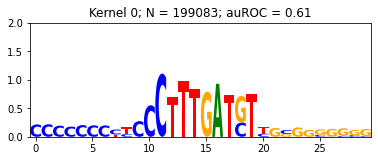

In [25]:
fig, axes = plt.subplots(4,4, figsize=(20,8), tight_layout=True)
for plot_i, i in enumerate(np.argsort(list(AUCs.values()))[::-1]):
    n = df[df["kernel"] == i].shape[0]
    if n > 0:
        auc = AUCs[i]
        ax = axes.flatten()[plot_i]
        ppm = logomaker.alignment_to_matrix(df[df["kernel"] == i].seq, to_type="counts")
        for nuc in ["A", "C", "G", "T"]:
            if nuc not in ppm.columns:
                ppm[nuc] = 0.0
        ppm = ppm[["A", "C", "G", "T"]]
        ppm = ppm.div(ppm.sum(axis=1), axis=0)
        logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
        ax.set_ylim([0,2])
        ax.set_title("Kernel {0}; N = {1}; auROC = {2:.2f}".format(i, n, auc))
    else:
        ax = axes.flatten()[plot_i]
        fig.delaxes(ax)
        
for i in range(n_motifs, 16):
    fig.delaxes(axes.flatten()[i])

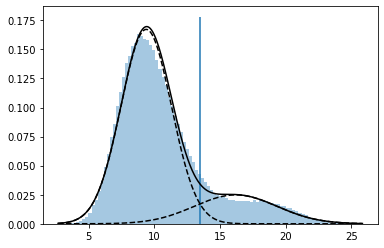

In [26]:
model = GaussianMixture(2).fit(df.score.values.reshape(-1,1))
x = np.linspace(np.min(df.score.values), np.max(df.score.values), 1000)
logprob = model.score_samples(x.reshape(-1, 1))
probs = model.predict_proba(x.reshape(-1, 1))
means = model.means_
index = np.argmax(means)
thresh = x[np.where(probs[:,index] > 0.5)[0]][0]
responsibilities = model.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]
fig, ax = plt.subplots()
_ = ax.hist(df.score, 100, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ymin, ymax = ax.get_ylim()
ax.vlines(x = thresh ,ymin=ymin, ymax=ymax)
tmp_df = df[(df["score"] > thresh)]
ppm = logomaker.alignment_to_matrix(tmp_df.seq, to_type="counts")
ppm = ppm[["A", "C", "G", "T"]]
ppm = ppm.div(ppm.sum(axis=1), axis=0)

(0.0, 2.0)

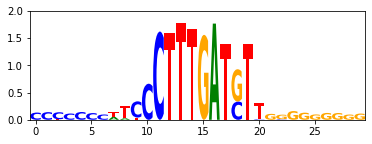

In [27]:
fig, ax = plt.subplots(figsize=(6,2))
logomaker.Logo(ppm.applymap(get_information_content), ax=ax)
ax.set_ylim([0,2])

In [28]:
with open(motif_out, "w") as f:
    print(">{0} {0}_{1}".format(TF, cycle), file=f)
    for i in range(ppm.shape[0]):
        print(" ".join(["%.5f" % v for v in ppm.values[i,:]]), file=f)